In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Load Data
df = pd.read_csv('/final_data.csv')

In [ ]:
# Data Preprocessing
# Drop the index column 'Unnamed: 0' if it exists
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

# Fill missing values
df.fillna(method='ffill', inplace=True)

# Encode categorical columns like 'batch_id', 'location', 'current_hop'
categorical_columns = ['batch_id', 'location', 'current_hop']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


<ipython-input-5-550ded0b2ed5>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [ ]:
# Feature Scaling
features = [
    'batch_id', 'location', 'current_hop', 'external_storage',
    'thermal_shipper_temp_reading', 'room_temp_reading', 'room_humidity_reading',
    'item_expiry_hours', 'ultra_low_temperature_freezer_hours',
    'out_of_bound_temperature_hours', 'refrigeration_temperature_hours',
    'month', 'hour', 'year'
]

X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Initialize and Train Isolation Forest Model
model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
model.fit(X_scaled)

IsolationForest(contamination=0.05, random_state=42)

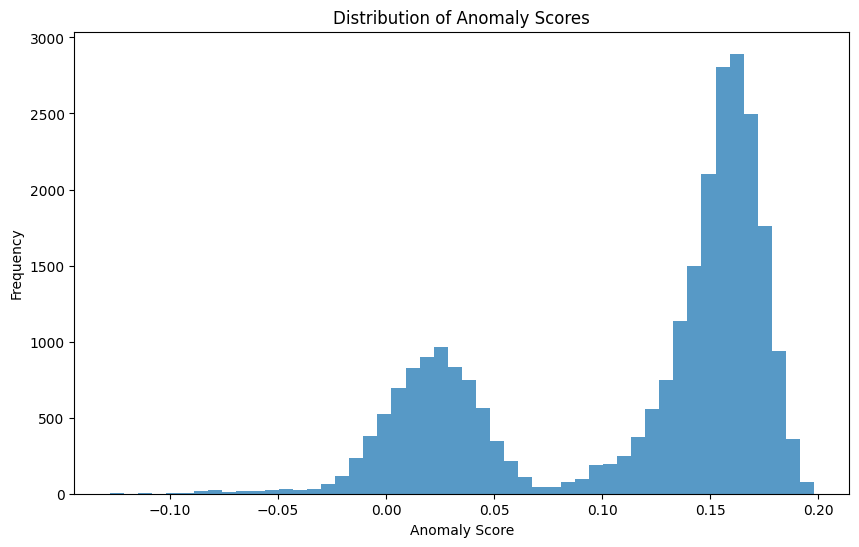

In [ ]:
# Predict Anomaly Scores
anomaly_scores = model.decision_function(X_scaled)
anomalies = model.predict(X_scaled)

# Plotting Anomalies
plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores, bins=50, alpha=0.75)
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Display number of anomalies
print(f"Number of anomalies detected: {np.sum(anomalies == -1)}")

# Mark anomalies in DataFrame
df['anomaly'] = np.where(anomalies == -1, 1, 0)  # 1 for anomaly, 0 for normal
df['anomaly_score'] = anomaly_scores

# Enhance the features with Isolation Forest outputs
X_enhanced = np.hstack((X_scaled, df[['anomaly', 'anomaly_score']].values))


Number of anomalies detected: 1319


In [ ]:
# Display DataFrame with anomalies
print(df[df['anomaly'] == -1])
df.to_csv('validation.csv')

Empty DataFrame
Columns: [Unnamed: 0.1, date, item_id, batch_id, location, current_hop, external_storage, thermal_shipper_temp_reading, room_temp_reading, room_humidity_reading, item_expiry_hours, ultra_low_temperature_freezer_hours, out_of_bound_temperature_hours, refrigeration_temperature_hours, month, hour, year, anomaly, anomaly_score]
Index: []


In [ ]:
# Updated Train-Test Split with Enhanced Features
X_train, X_test, y_train, y_test = train_test_split(
    X_enhanced, df['anomaly'], test_size=0.2, random_state=42
)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import time

# Mark anomalies as 1 and normal as 0 for metric calculation
y_true = np.where(df['anomaly'] == -1, 1, 0)  # 1 for anomalies, 0 for normal

# Measure execution time
start_time = time.time()
y_pred = model.predict(X_scaled)
execution_time = time.time() - start_time

# Update predictions (Isolation Forest gives -1 for anomaly, 1 for normal)
y_pred = np.where(y_pred == -1, 1, 0)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Calculate ROC-AUC Score only if both classes are present
if len(np.unique(y_true)) > 1:
    roc_score = roc_auc_score(y_true, y_pred)
    print(f"\nROC-AUC Score: {roc_score:.4f}")
else:
    print("\nROC-AUC Score cannot be calculated because only one class is present in y_true.")

# Execution Time
print(f"\nModel Prediction Time: {execution_time:.4f} seconds")


Confusion Matrix:
[[25054  1319]
 [    0     0]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     26373
           1       0.00      0.00      0.00         0

    accuracy                           0.95     26373
   macro avg       0.50      0.47      0.49     26373
weighted avg       1.00      0.95      0.97     26373


ROC-AUC Score cannot be calculated because only one class is present in y_true.

Model Prediction Time: 0.1449 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


660/660 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9362 - loss: 0.2081 - val_accuracy: 0.9683 - val_loss: 0.0757
Epoch 2/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9634 - loss: 0.0891 - val_accuracy: 0.9706 - val_loss: 0.0740
Epoch 3/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9652 - loss: 0.0823 - val_accuracy: 0.9700 - val_loss: 0.0679
Epoch 4/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9637 - loss: 0.0871 - val_accuracy: 0.9735 - val_loss: 0.0639
Epoch 5/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9710 - loss: 0.0731 - val_accuracy: 0.9755 - val_loss: 0.0617
Epoch 6/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9706 - loss: 0.0694 - val_accuracy: 0.9738 - val_loss: 0.0658
Epoch 7/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9685 - loss: 0.0706 - val_accuracy: 0.9757 - val_loss: 0.0574
Epoch 8/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9694 - loss: 0.0698 - val_accuracy: 0.9788 - val_

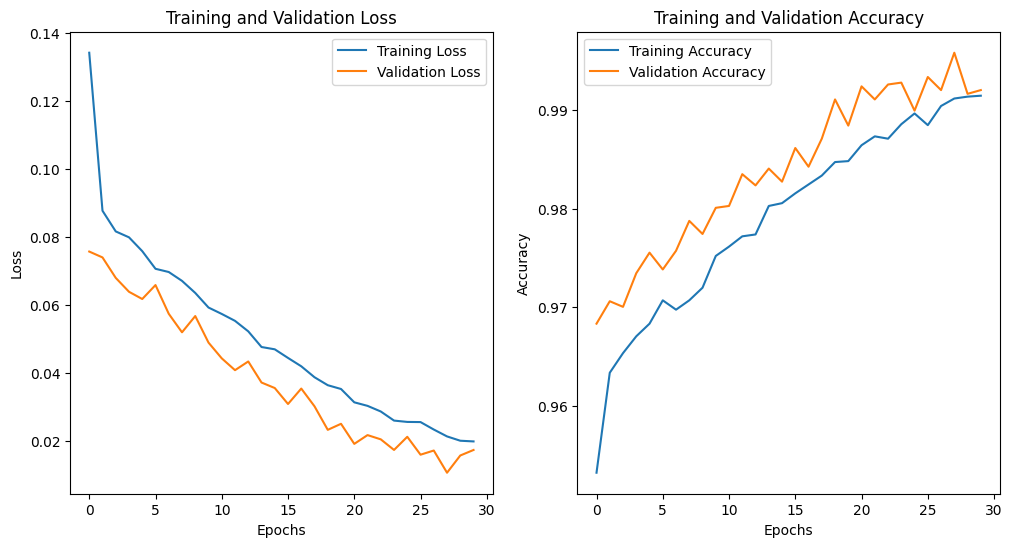


Summary of Predictions:
anomaly  nn_pred
0        0          23660
         1           1394
1        0           1232
         1             87
Name: count, dtype: int64


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.utils import shuffle

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
n_folds = 5

# Prepare Out-of-Fold arrays for predictions
oof_predictions = np.zeros(X_scaled.shape[0])
oof_scores = np.zeros(X_scaled.shape[0])

# Generate OOF Features using Isolation Forest
for train_index, test_index in kf.split(X_scaled):
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold = y_true[train_index]

    # Initialize and fit Isolation Forest model
    fold_model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    fold_model.fit(X_train_fold)

    # OOF Predictions and Scores
    oof_predictions[test_index] = fold_model.predict(X_test_fold)
    oof_scores[test_index] = fold_model.decision_function(X_test_fold)

# Convert OOF predictions for neural network training
X_train_nn = np.hstack((X_scaled, oof_scores.reshape(-1, 1)))  # Adding anomaly scores as a feature
y_train_nn = np.where(oof_predictions == -1, 1, 0)  # 1 = Anomaly, 0 = Normal

# Shuffle the training data to avoid any sequential pattern
X_train_nn, y_train_nn = shuffle(X_train_nn, y_train_nn, random_state=42)

# Define a neural network model
model_nn = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train_nn.shape[1],)),  # Adjusted input shape
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the neural network model
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network model
history = model_nn.fit(X_train_nn, y_train_nn, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the neural network model
y_pred_nn = model_nn.predict(X_train_nn)
y_pred_nn_binary = np.where(y_pred_nn > 0.5, 1, 0)

# Calculate accuracy
accuracy_nn = accuracy_score(y_train_nn, y_pred_nn_binary)
print(f"\nNeural Network Accuracy on OOF Data: {accuracy_nn:.4f}")

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_train_nn, y_pred_nn_binary)
print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_train_nn, y_pred_nn_binary))

# Plot Training History
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Output predictions to CSV
df['nn_pred'] = y_pred_nn_binary
df['anomaly_score'] = oof_scores
df[['date', 'item_id', 'batch_id', 'location', 'current_hop', 'anomaly', 'anomaly_score', 'nn_pred']].to_csv('enhanced_nn_predictions.csv', index=False)

# Summary of Predictions
print("\nSummary of Predictions:")
print(df[['anomaly', 'nn_pred']].value_counts())


In [ ]:
# Assume 'model_nn' is your trained model
model_nn.save('model_nn.h5')  # Save the model as a .h5 file
print("Model saved as 'model_nn.h5'")


Model saved as 'model_nn.h5'


In [ ]:
# Generate Predictions with the trained Neural Network
y_pred_nn = model_nn.predict(X_train_nn)
df['nn_pred'] = np.where(y_pred_nn > 0.5, 1, 0)  # Binary predictions (1 = anomaly, 0 = normal)

# Output the predictions to a CSV file
df[['date', 'item_id', 'batch_id', 'location', 'current_hop', 'anomaly', 'anomaly_score', 'nn_pred']].to_csv('enhanced_predictions.csv', index=False)

# Display a summary of the predictions
print(df[['anomaly', 'anomaly_score', 'nn_pred']].value_counts())


825/825 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
anomaly  anomaly_score  nn_pred
0        0.046312       0          2
         0.048368       0          2
         0.035915       0          2
         0.139100       0          2
         0.036495       0          2
                                  ..
         0.125824       0          1
         0.125790       0          1
         0.125774       1          1
         0.125770       0          1
1        0.037799       0          1
Name: count, Length: 26354, dtype: int64


In [ ]:
import joblib

# After training your model
joblib.dump(model, 'model_nn.pkl')  # Save model to file


['model_nn.pkl']

In [ ]:
!pip install dash



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [ ]:
!pip install pyngrok

In [ ]:
!pip install plotly

In [ ]:
!pip install jupyter-dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [ ]:
import pandas as pd

# Load the enhanced predictions file
enhanced_predictions = pd.read_csv('enhanced_predictions.csv')  # Replace with your actual file path

# Display the column names in the enhanced_predictions dataset
print("Columns in the enhanced_predictions dataset:")
print(enhanced_predictions.columns)


Columns in the enhanced_predictions dataset:
Index(['date', 'item_id', 'batch_id', 'location', 'current_hop', 'anomaly',
       'anomaly_score', 'nn_pred'],
      dtype='object')


<ipython-input-23-a3f0882f61dc>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='anomaly', data=enhanced_predictions, palette='coolwarm', label='True Anomaly')
<ipython-input-23-a3f0882f61dc>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='nn_pred', data=enhanced_predictions, palette='Blues', label='Predicted Anomaly')


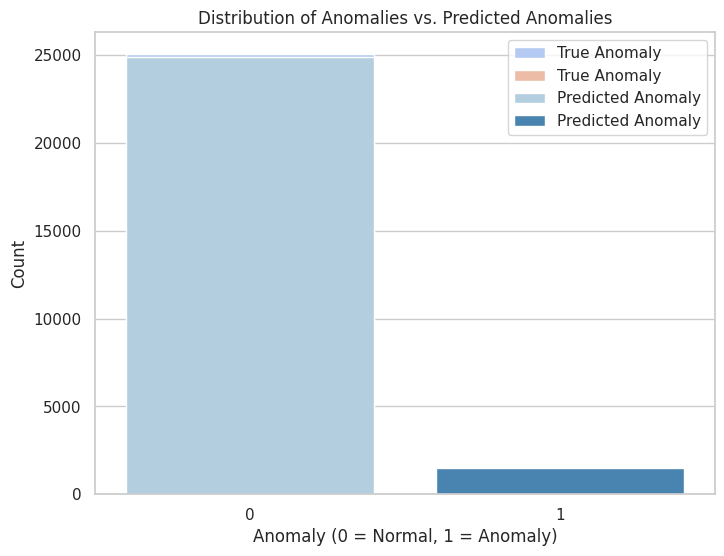

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the enhanced predictions file
enhanced_predictions = pd.read_csv('enhanced_predictions.csv')  # Replace with your actual file path

# Set seaborn style for plots
sns.set(style="whitegrid")

# 1. Distribution of Anomalies vs. Predictions
plt.figure(figsize=(8, 6))
sns.countplot(x='anomaly', data=enhanced_predictions, palette='coolwarm', label='True Anomaly')
sns.countplot(x='nn_pred', data=enhanced_predictions, palette='Blues', label='Predicted Anomaly')
plt.title('Distribution of Anomalies vs. Predicted Anomalies')
plt.xlabel('Anomaly (0 = Normal, 1 = Anomaly)')
plt.ylabel('Count')
plt.legend()
plt.show()

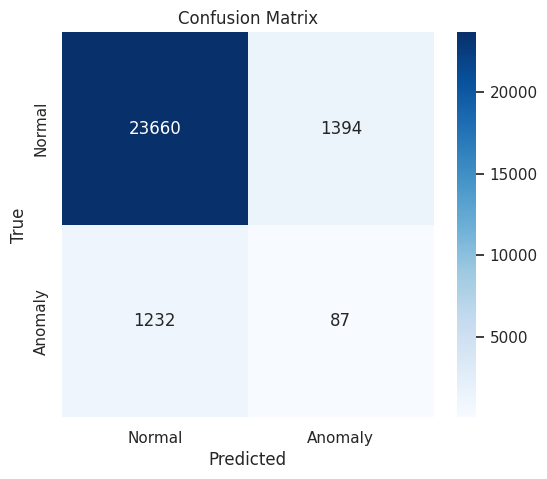

In [ ]:
# 2. Confusion Matrix to Evaluate Predictions
conf_matrix = confusion_matrix(enhanced_predictions['anomaly'], enhanced_predictions['nn_pred'])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<ipython-input-25-3039127b3130>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='anomaly', y='current_hop', data=enhanced_predictions, palette='Set2')


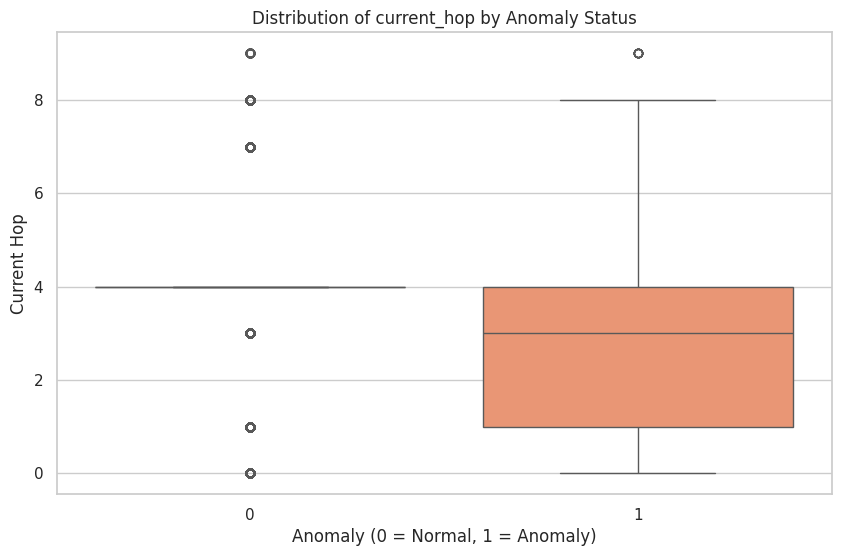

<ipython-input-25-3039127b3130>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='anomaly', y='location', data=enhanced_predictions, palette='Set1')


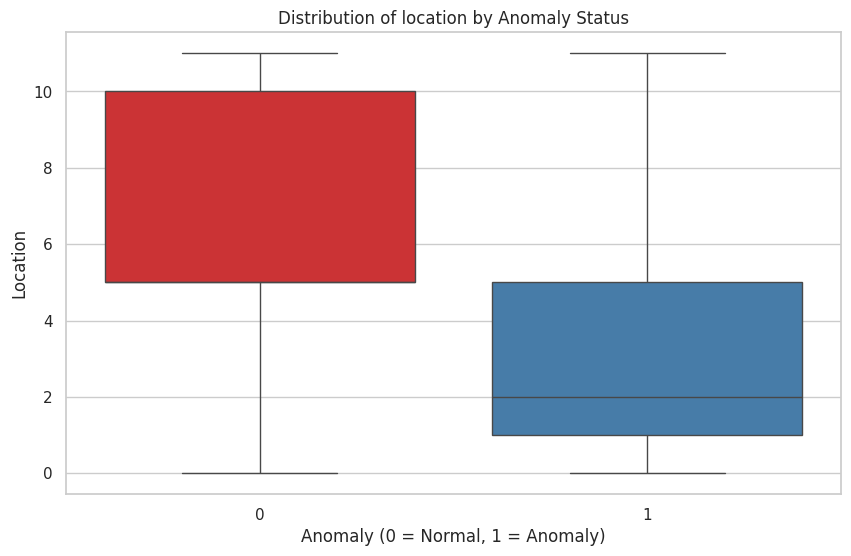

In [ ]:
# 3. Feature Distribution by Anomaly (Visualizing 'current_hop', 'location', and 'anomaly_score')
plt.figure(figsize=(10, 6))
sns.boxplot(x='anomaly', y='current_hop', data=enhanced_predictions, palette='Set2')
plt.title('Distribution of current_hop by Anomaly Status')
plt.xlabel('Anomaly (0 = Normal, 1 = Anomaly)')
plt.ylabel('Current Hop')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='anomaly', y='location', data=enhanced_predictions, palette='Set1')
plt.title('Distribution of location by Anomaly Status')
plt.xlabel('Anomaly (0 = Normal, 1 = Anomaly)')
plt.ylabel('Location')
plt.show()


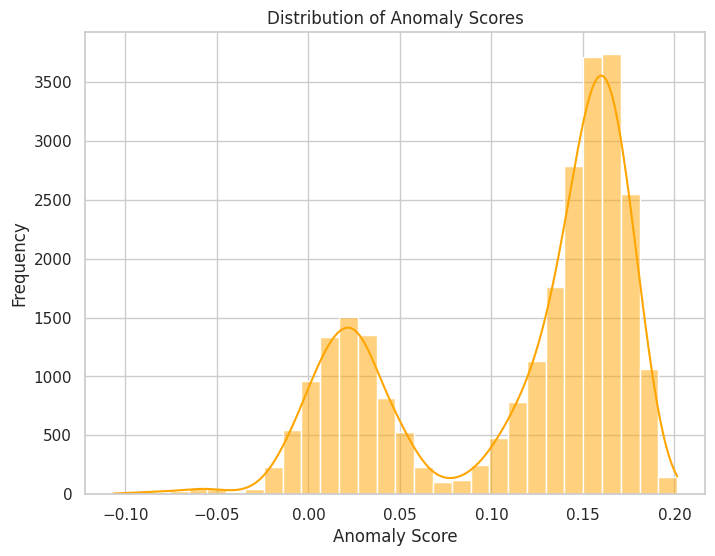

In [ ]:
# 4. Anomaly Score Distribution
plt.figure(figsize=(8, 6))
sns.histplot(enhanced_predictions['anomaly_score'], kde=True, bins=30, color='orange')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()



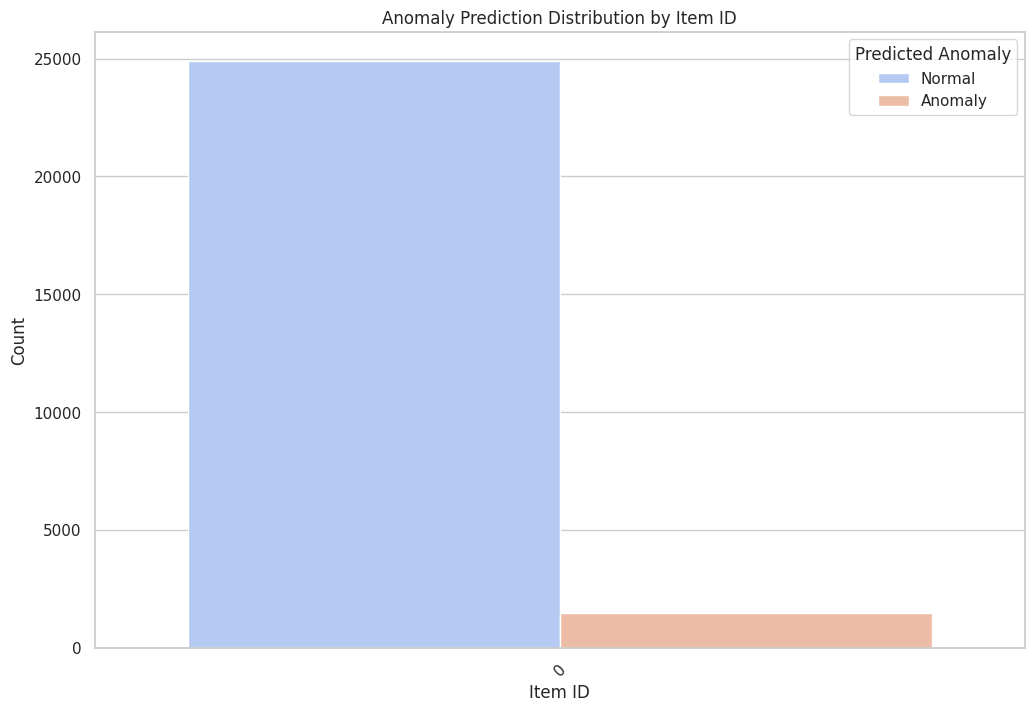

In [ ]:
# 5. Bar Plot for Distribution of Anomalies by Item ID
plt.figure(figsize=(12, 8))
sns.countplot(x='item_id', hue='nn_pred', data=enhanced_predictions, palette='coolwarm')
plt.title('Anomaly Prediction Distribution by Item ID')
plt.xlabel('Item ID')
plt.ylabel('Count')
plt.legend(title='Predicted Anomaly', labels=['Normal', 'Anomaly'])
plt.xticks(rotation=45)
plt.show()


In [ ]:
# 6. Accuracy of the predictions
accuracy = (enhanced_predictions['anomaly'] == enhanced_predictions['nn_pred']).mean()
print(f"Accuracy of the Neural Network Predictions: {accuracy:.4f}")

Accuracy of the Neural Network Predictions: 0.9004
